# Assignment 3

# Instructions

1. You have to use only this notebook for all your code.
2. All the results and plots should be mentioned in this notebook.
3. For final submission, submit this notebook along with the report ( usual 2-4 pages, latex typeset, which includes the challenges faces and details of additional steps, if any)
4. Marking scheme
    -  **60%**: Your code should be able to detect bounding boxes using resnet 18, correct data loading and preprocessing. Plot any 5 correct and 5 incorrect sample detections from the test set in this notebook for both the approached (1 layer and 2 layer detection), so total of 20 plots.
    -  **20%**: Use two layers (multi-scale feature maps) to detect objects independently as in SSD (https://arxiv.org/abs/1512.02325).  In this method, 1st detection will be through the last layer of Resnet18 and the 2nd detection could be through any layer before the last layer. SSD uses lower resolution layers to detect larger scale objects. 
    -  **20%**: Implement Non-maximum suppression (NMS) (should not be imported from any library) on the candidate bounding boxes.
    
5. Report AP for each of the three class and mAP score for the complete test set.

In [6]:
from __future__ import division, print_function, unicode_literals
import sys
print(sys.path)
import numpy as np
import os
import xml.etree.ElementTree as ET
import torch
import torch.utils.data as data
from torchvision import models
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
from copy import deepcopy
import pickle as pkl
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()
# Import other modules if required
# Can use other libraries as well

resnet_input = 224#size of resnet18 input images

['', '/usr/lib/python2.7', '/usr/lib/python2.7/plat-x86_64-linux-gnu', '/usr/lib/python2.7/lib-tk', '/usr/lib/python2.7/lib-old', '/usr/lib/python2.7/lib-dynload', '/users/btech/siddarth/.local/lib/python2.7/site-packages', '/usr/local/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages/PILcompat', '/usr/local/lib/python2.7/dist-packages/IPython/extensions', '/users/btech/siddarth/.ipython']


In [18]:
# Choose your hyper-parameters using validation data
batch_size = 64
num_epochs = 5
learning_rate =  0.001
hyp_momentum = 0.9

## Build the data
Use the following links to locally download the data:
<br/>Training and validation:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
<br/>Testing data:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
<br/>The dataset consists of images from 20 classes, with detection annotations included. The JPEGImages folder houses the images, and the Annotations folder has the object-wise labels for the objects in one xml file per image. You have to extract the object information, i.e. the [xmin, ymin] (the top left x,y co-ordinates) and the [xmax, ymax] (the bottom right x,y co-ordinates) of only the objects belonging to the three classes(aeroplane, bottle, chair). For parsing the xml file, you can import xml.etree.ElementTree for you. <br/>
<br/> Organize the data as follows:
<br/> For every image in the dataset, extract/crop the object patch from the image one by one using their respective co-ordinates:[xmin, ymin, xmax, ymax], resize the image to resnet_input, and store it with its class label information. Do the same for training/validation and test datasets. <br/>
##### Important
You also have to collect data for an extra background class which stands for the class of an object which is not a part of any of the 20 classes. For this, you can crop and resize any random patches from an image. A good idea is to extract patches that have low "intersection over union" with any object present in the image frame from the 20 Pascal VOC classes. The number of background images should be roughly around those of other class objects' images. Hence the total classes turn out to be four. This is important for applying the sliding window method later.


In [3]:
classes = ('__background__',
           'aeroplane',
           'bottle','chair'
           )

from collections import defaultdict

def etree_to_dict(t):
    d = {t.tag: {} if t.attrib else None}
    children = list(t)
    if children:
        dd = defaultdict(list)
        for dc in map(etree_to_dict, children):
            for k, v in dc.items():
                dd[k].append(v)
        d = {t.tag: {k: v[0] if len(v) == 1 else v
                     for k, v in dd.items()}}
    if t.attrib:
        d[t.tag].update(('@' + k, v)
                        for k, v in t.attrib.items())
    if t.text:
        text = t.text.strip()
        if children or t.attrib:
            if text:
              d[t.tag]['#text'] = text
        else:
            d[t.tag] = text
    return d


In [36]:
def build_dataset():
    # Begin
    root_dir = '/data/siddarth/Asgn3/train/VOC2007/'
    image_dir = os.path.join(root_dir, 'JPEGImages')
    annotation_dir = os.path.join(root_dir, 'Annotations')
    
    result = {}
    for filename in os.listdir(annotation_dir):
        f = os.path.join(annotation_dir, filename)
        root = ET.parse(f).getroot()
        obj = etree_to_dict(root)
        img_name = obj['annotation']['filename']
        objt = obj['annotation']['object']
        
        obj_list = []
#         print('hello')
        if type(objt) is dict:
            if objt['name'] in classes:
#                 print('yes')
                img_file = os.path.join(image_dir, img_name)
                img = Image.open(img_file)
                area = (int(objt['bndbox']['xmin']), int(objt['bndbox']['ymin']), int(objt['bndbox']['xmax']), int(objt['bndbox']['ymax']))
                crop = img.crop(area)
#                 plt.imshow(np.asarray(crop))
#                 plt.show()
#                 print(objt['name'])
                obj_list.append((crop, objt['name']))
                result[img_name] = deepcopy(obj_list)
                
        if type(objt) is list:
            tmp = objt
            obj_list = []
            for objt in tmp:
                if objt['name'] in classes:
#                     print('yes2')
                    img_file = os.path.join(image_dir, img_name)
                    img = Image.open(img_file)
                    area = (int(objt['bndbox']['xmin']), int(objt['bndbox']['ymin']), int(objt['bndbox']['xmax']), int(objt['bndbox']['ymax']))
                    crop = img.crop(area)
#                     plt.imshow(np.asarray(crop))
#                     plt.show()
#                     print(objt['name'])
                    obj_list.append((crop, objt['name']))
            if obj_list:
                result[img_name] = deepcopy(obj_list)
                #         print(obj)
#         break
        
    return result

# with open('test_data.pkl', 'wb') as f:
#     pkl.dump(build_dataset(), f)
# print(build_dataset())
# build_dataset()


In [41]:
THRESHOLD = 0.1
def intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
 
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
 
    # return the intersection over union value
    return iou

def build_background():
#     x_min = np.random.randint()
    root_dir = '/data/siddarth/Asgn3/train/VOC2007/'
    image_dir = os.path.join(root_dir, 'JPEGImages')
    annotation_dir = os.path.join(root_dir, 'Annotations')
    
    result = {}
    c = 0
    for filename in os.listdir(annotation_dir):
        f = os.path.join(annotation_dir, filename)
        root = ET.parse(f).getroot()
        obj = etree_to_dict(root)
        
        obj_list = []
        img_name = obj['annotation']['filename']
        objt = obj['annotation']['object']
        
        if type(objt) is dict:
            area = (int(objt['bndbox']['xmin']), int(objt['bndbox']['ymin']), int(objt['bndbox']['xmax']), int(objt['bndbox']['ymax']))
            obj_list.append(area)
#             result[img_name] = deepcopy(obj_list)
                
        if type(objt) is list:
            tmp = objt
            obj_list = []
            for objt in tmp:
                area = (int(objt['bndbox']['xmin']), int(objt['bndbox']['ymin']), int(objt['bndbox']['xmax']), int(objt['bndbox']['ymax']))
                obj_list.append(area)
                
        img_size = obj['annotation']['size']
        w = int(img_size['width'])
        h = int(img_size['height'])
        is_good = True
        while is_good:
            is_good = False
            x_min = np.random.randint(0, w-2)
            y_min = np.random.randint(0, h-2)
            del_x = np.random.randint(1, w-x_min)
            del_y = np.random.randint(1, h-y_min)

            candidate = (x_min, y_min, x_min+del_x, y_min+del_x)
            length = len(obj_list)
            iou_list = []

            for box in obj_list:
                if intersection_over_union(candidate, box) > THRESHOLD:
#                     print('run again')
#                     print(intersection_over_union(candidate, box))
                    c+=1
                    is_good = True
                    break
        img_file = os.path.join(image_dir, img_name)
        img = Image.open(img_file)
        crop = img.crop(candidate)
        
        print(candidate)
        
        result[img_name] = (crop, '__background__')      
        
    with open('train_background.pkl', 'wb') as f:
        pkl.dump(result, f)
#     print(c)
        
        
build_background()

(278, 333, 387, 442)
(484, 315, 493, 324)
(452, 41, 498, 87)
(111, 33, 213, 135)
(55, 254, 309, 508)
(280, 48, 319, 87)
(447, 306, 450, 309)
(2, 356, 464, 818)
(220, 130, 226, 136)
(396, 84, 442, 130)
(466, 104, 478, 116)
(410, 160, 491, 241)
(463, 43, 480, 60)
(413, 35, 479, 101)
(361, 62, 417, 118)
(167, 304, 185, 322)
(61, 391, 220, 550)
(416, 44, 425, 53)
(209, 9, 434, 234)
(51, 176, 207, 332)
(35, 130, 342, 437)
(442, 193, 494, 245)
(483, 27, 487, 31)
(105, 193, 172, 260)
(206, 304, 228, 326)
(211, 17, 213, 19)
(175, 107, 251, 183)
(237, 275, 357, 395)
(489, 292, 498, 301)
(373, 313, 429, 369)
(254, 119, 392, 257)
(45, 252, 482, 689)
(8, 240, 119, 351)
(178, 49, 410, 281)
(283, 280, 351, 348)
(183, 182, 238, 237)
(395, 141, 472, 218)
(469, 152, 479, 162)
(29, 305, 38, 314)
(424, 240, 486, 302)
(424, 226, 481, 283)
(59, 496, 126, 563)
(339, 84, 370, 115)
(418, 312, 434, 328)
(231, 160, 247, 176)
(353, 317, 481, 445)
(406, 323, 441, 358)
(386, 200, 423, 237)
(109, 97, 268, 256)
(417

In [44]:
class voc_dataset(torch.utils.data.Dataset): # Extend PyTorch's Dataset class
    def __init__(self, root_dir, train, transform=None):
        # Begin
        self.train = train
        self.transform = transform
        self.root_dir = root_dir
        if train:
            self.dataset = []
            with open('train_data.pkl', 'rb') as f:
                data = pkl.load(f)
                
            for k, v in data.items():
                for x in v:
                    self.dataset.append(x)
#                     plt.imshow(np.asarray(x[0]))
#                     plt.show()
#                     print(x[1])
                    
            with open('train_background.pkl', 'rb') as f:
                data = pkl.load(f)
                
            for k, v in data.items():
                self.dataset.append(v)
#                 plt.imshow(np.asarray(v[0]))
#                 plt.show()
#                 print(v[1])
                
        else:
            self.dataset = []
            with open('test_data.pkl', 'rb') as f:
                data = pkl.load(f)
                
            for k, v in data.items():
                for x in v:
                    self.dataset.append(x)          
            
    def __len__(self):
        # Begin
        if self.train:
            return len(self.dataset)
        else:
            return len(self.dataset)
        
    def __getitem__(self, idx):
       # Begin
        img, label = self.dataset[idx]
        
        if self.transform is not None:
            img = self.transform(img)
            
        return img, classes.index(label)
    
# voc_dataset(root_dir='/home/ks1d/Documents/CS783A/Assignment-3/train/VOC2007/', train=True)

## Train the netwok
<br/>You can train the network on the created dataset. This will yield a classification network on the 4 classes of the VOC dataset. 

In [61]:
composed_transform = transforms.Compose([transforms.Scale((resnet_input,resnet_input)),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor()
                                         ])
test_transform = transforms.Compose([transforms.Scale((resnet_input, resnet_input)),
                                    transforms.ToTensor()])
train_dataset = voc_dataset(root_dir='/home/ks1d/Documents/CS783A/Assignment-3/train/', train=True, transform=composed_transform) # Supply proper root_dir
test_dataset = voc_dataset(root_dir='/home/ks1d/Documents/CS783A/Assignment-3/test/', train=False, transform=composed_transform) # Supply proper root_dir

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### Fine-tuning
Use the pre-trained network to fine-tune the network in the following section:

In [46]:
resnet18 = models.resnet18(pretrained=True)

resnet18.fc = nn.Linear(resnet18.fc.in_features, 4)

# Add code for using CUDA here
resnet18 = resnet18.cuda()

In [47]:
criterion = nn.CrossEntropyLoss()
# Update if any errors occur
optimizer = torch.optim.SGD(resnet18.parameters(), learning_rate, hyp_momentum)

In [55]:
def test_acc(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.cuda(); target = target.cuda()
            #data, target = data.to(device), target.to(device)
            output = model(data)
            _, preds = torch.max(output, 1)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [56]:
#One Layer Detection
def train():
    # Begin
    for epoch in range(num_epochs):
        resnet18.train()
        print("Epoch number {0}".format(epoch+1))
        s = 0
        total_loss = 0
        for idx, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            x = x.cuda()
#             print(x.shape)
#             break
            outputs = resnet18(x)
            _, pred = torch.max(outputs, 1)
            y = y.cuda()
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()*x.size(0)
            s+=torch.sum(pred==y.data)
            
            
        print("Epoch loss {0}".format(float(total_loss)/len(train_loader)))
        print("Train Accuracy {0}".format(float(s)/float(len(train_dataset))))
        
        test_acc(resnet18, test_loader)

In [57]:
%time train()

Epoch number 1
Epoch loss 1.14126068379
Train Accuracy 0.995815334773

Test set: Average loss: 0.0043, Accuracy: 2143/2342 (92%)

Epoch number 2
Epoch loss 0.701953258237
Train Accuracy 0.99851511879

Test set: Average loss: 0.0053, Accuracy: 2101/2342 (90%)

Epoch number 3
Epoch loss 0.737292823093
Train Accuracy 0.997840172786

Test set: Average loss: 0.0048, Accuracy: 2135/2342 (91%)

Epoch number 4
Epoch loss 0.5087150695
Train Accuracy 0.999055075594

Test set: Average loss: 0.0054, Accuracy: 2109/2342 (90%)

Epoch number 5
Epoch loss 0.442572160785
Train Accuracy 0.999325053996

Test set: Average loss: 0.0056, Accuracy: 2108/2342 (90%)

CPU times: user 4min 33s, sys: 58.5 s, total: 5min 31s
Wall time: 6min 5s


In [ ]:
#Two Layer Detection (SSD)
def train():
    # Begin

In [ ]:
%time train()

# Testing and Accuracy Calculation
For applying detection, use a slding window method to test the above trained trained network on the detection task:<br/>
Take some windows of varying size and aspect ratios and slide it through the test image (considering some stride of pixels) from left to right, and top to bottom, detect the class scores for each of the window, and keep only those which are above a certain threshold value. There is a similar approach used in the paper -Faster RCNN by Ross Girshick, where he uses three diferent scales/sizes and three different aspect ratios, making a total of nine windows per pixel to slide. You need to write the code and use it in testing code to find the predicted boxes and their classes.

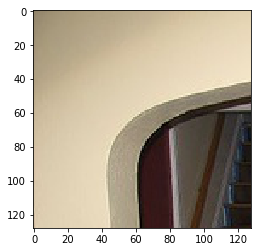

__background__


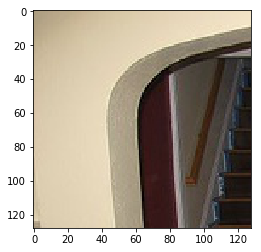

__background__


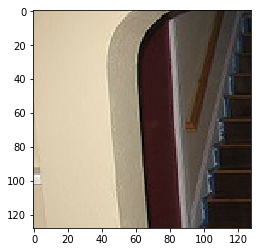

__background__


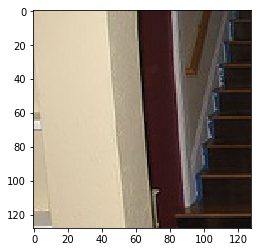

__background__


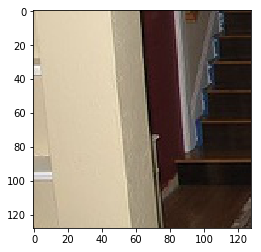

__background__


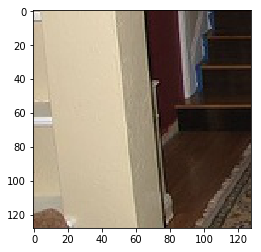

__background__


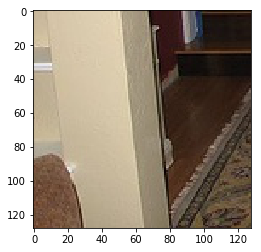

__background__


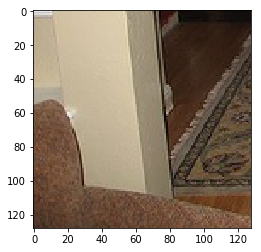

chair


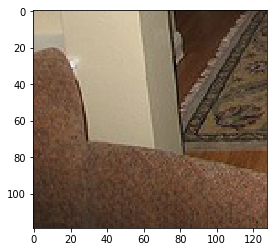

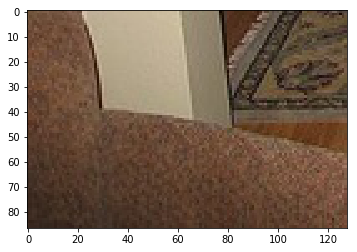

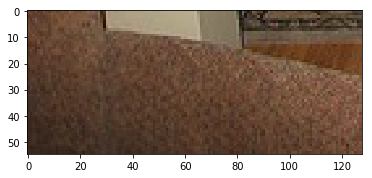

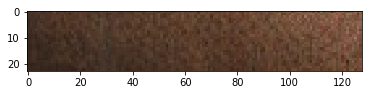

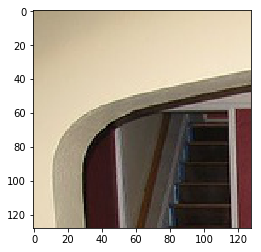

__background__


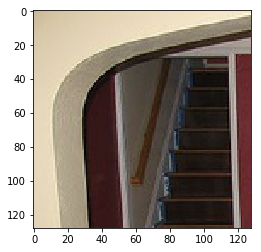

__background__


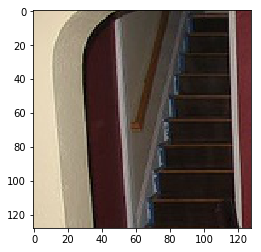

__background__


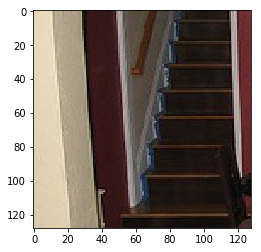

__background__


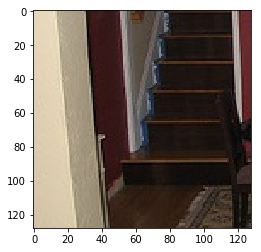

__background__


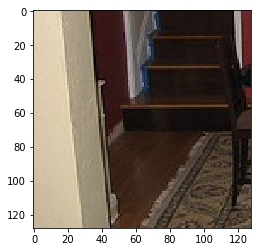

__background__


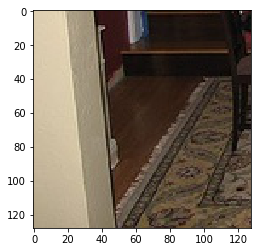

__background__


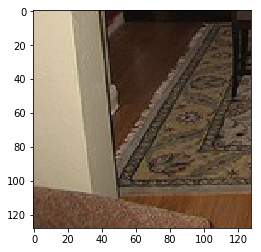

__background__


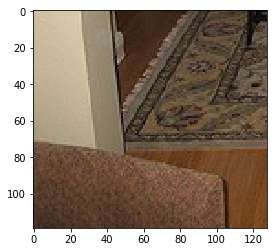

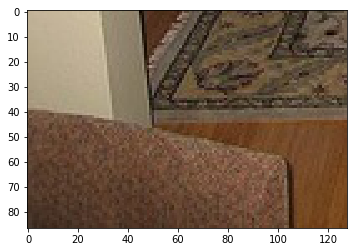

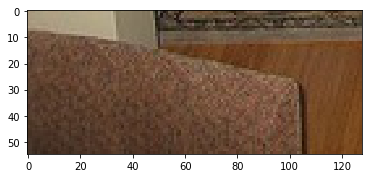

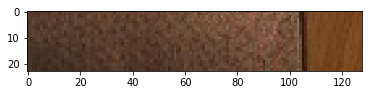

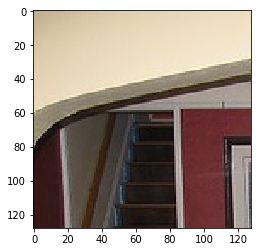

__background__


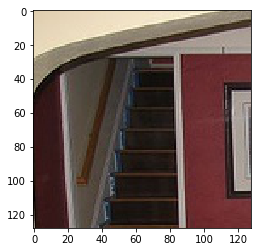

__background__


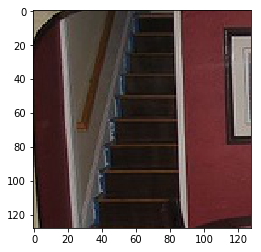

__background__


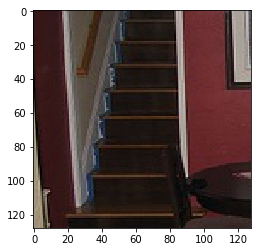

__background__


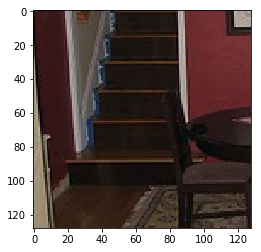

chair


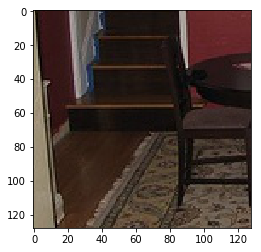

chair


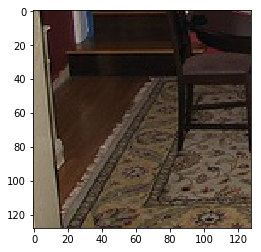

chair


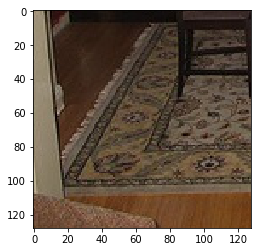

chair


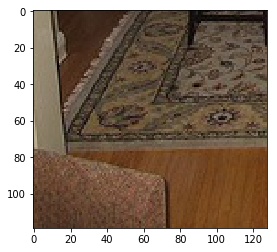

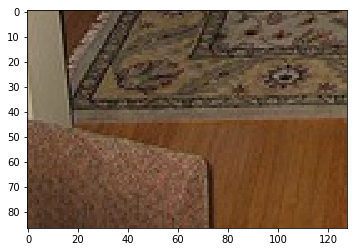

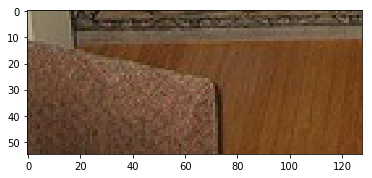

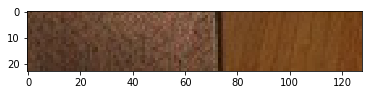

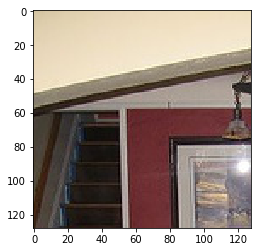

__background__


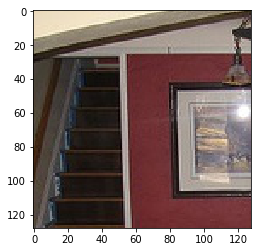

__background__


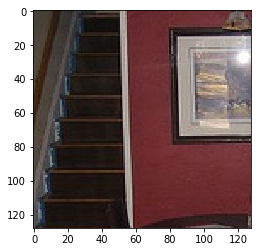

__background__


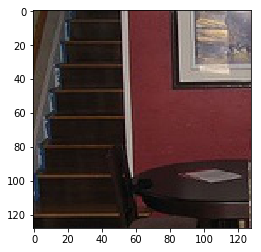

__background__


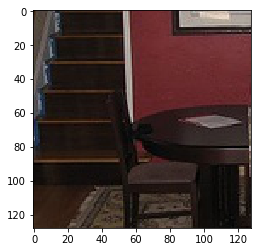

chair


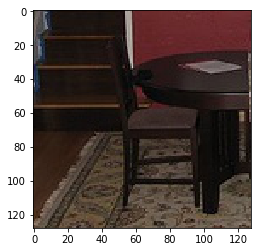

chair


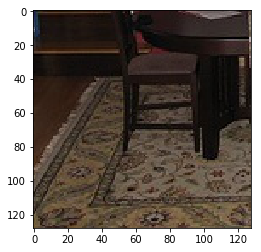

chair


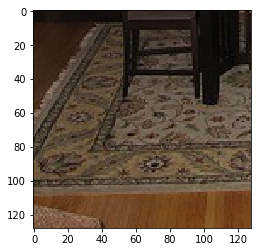

chair


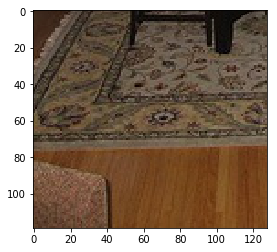

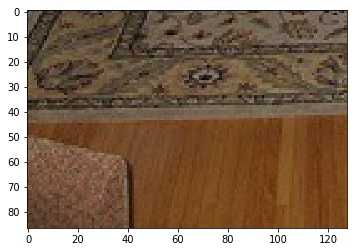

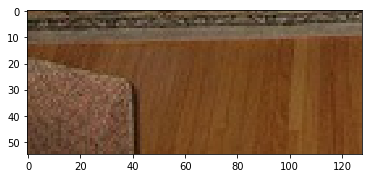

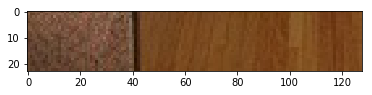

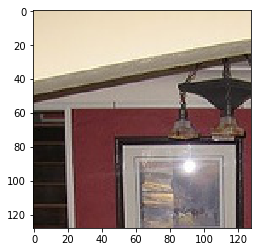

__background__


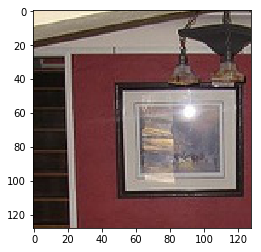

__background__


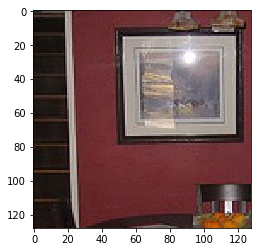

__background__


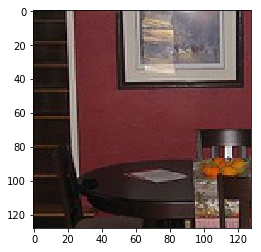

__background__


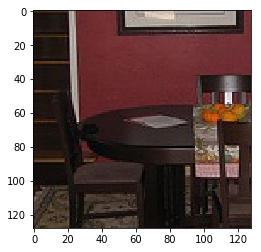

chair


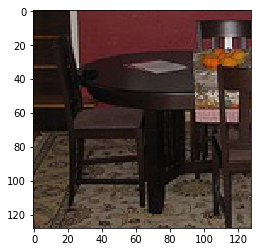

chair


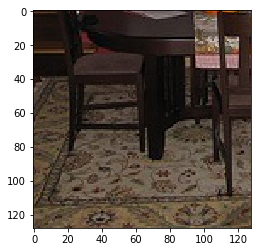

chair


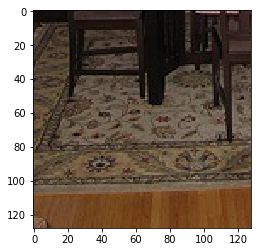

__background__


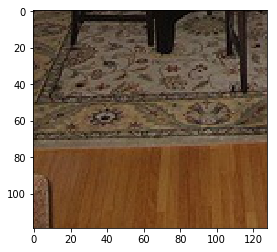

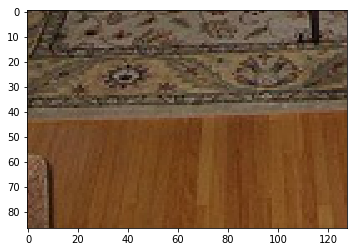

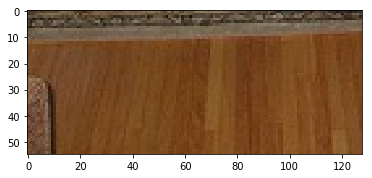

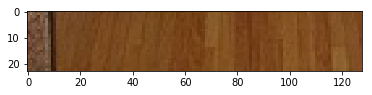

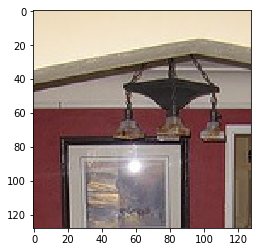

__background__


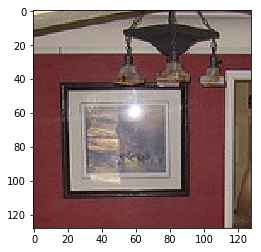

__background__


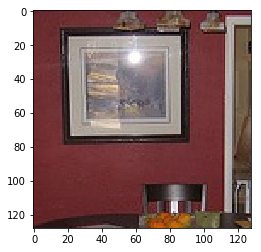

__background__


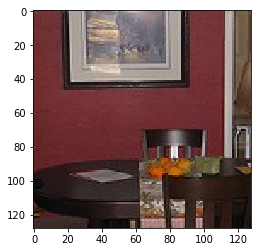

__background__


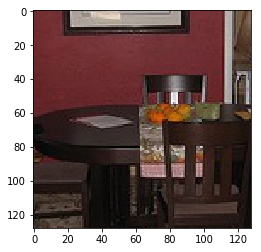

chair


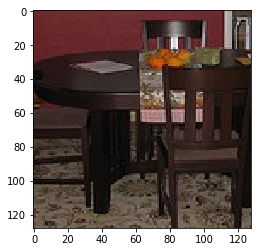

chair


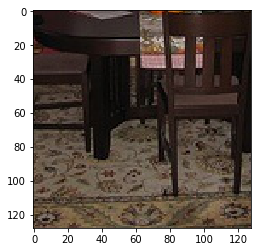

chair


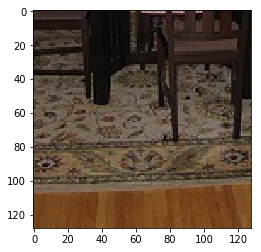

chair


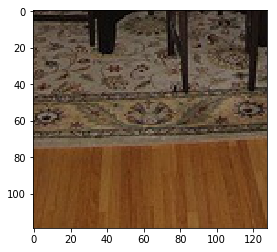

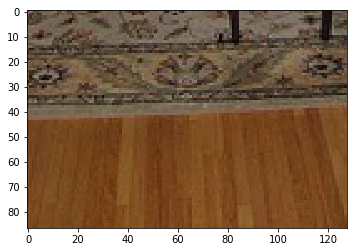

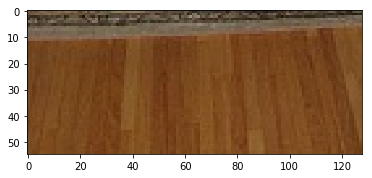

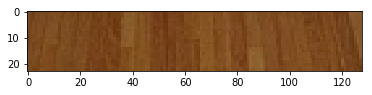

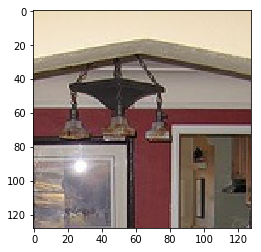

__background__


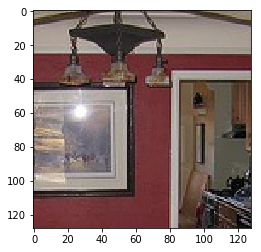

__background__


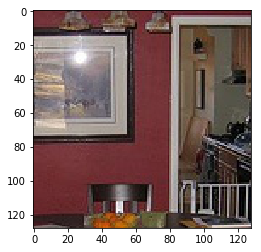

__background__


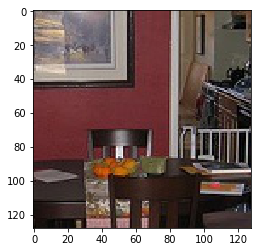

__background__


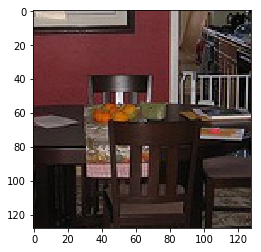

chair


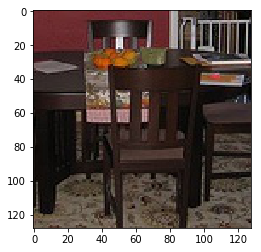

chair


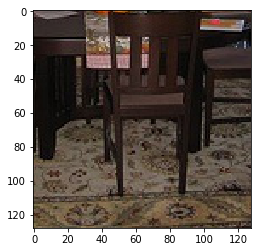

chair


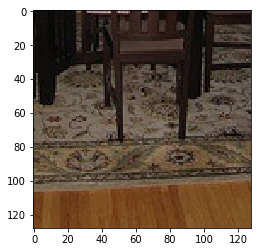

chair


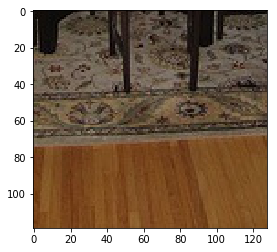

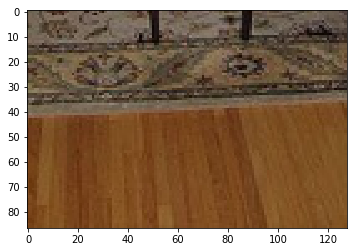

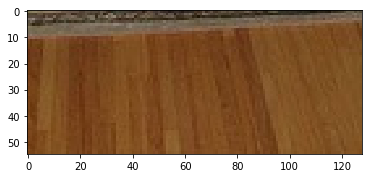

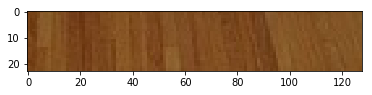

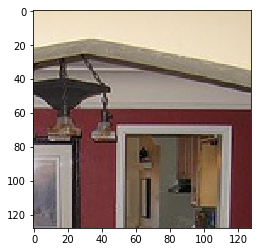

__background__


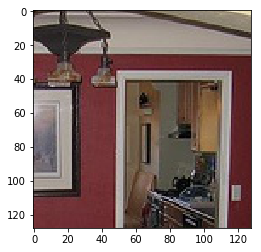

__background__


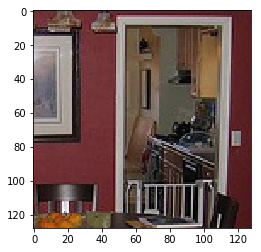

__background__


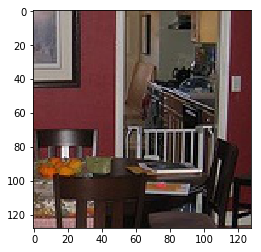

chair


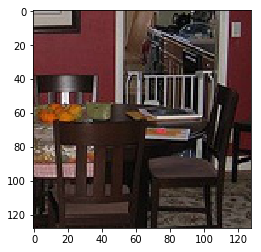

chair


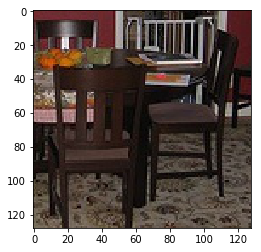

chair


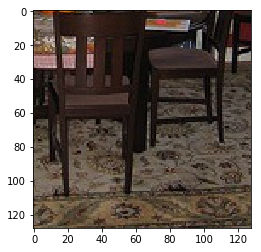

chair


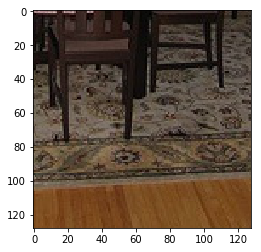

chair


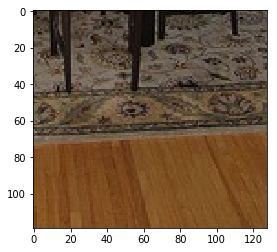

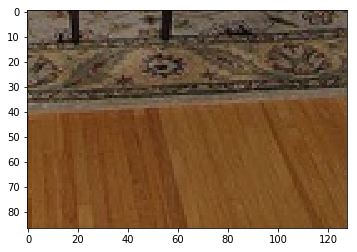

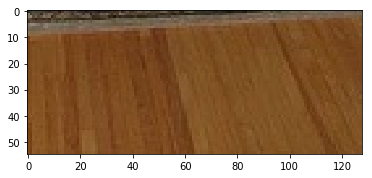

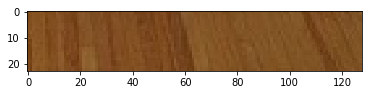

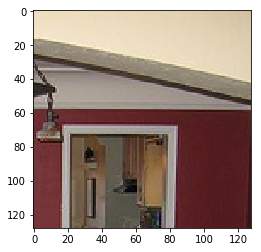

__background__


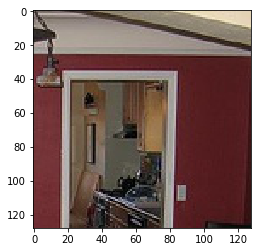

__background__


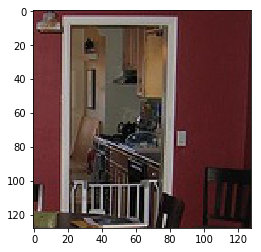

__background__


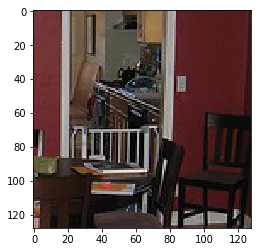

chair


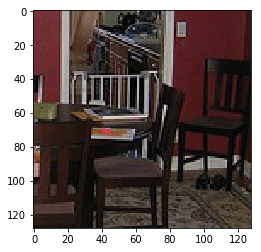

chair


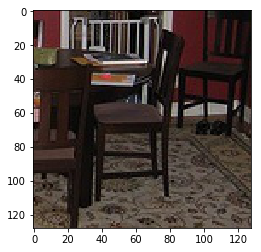

chair


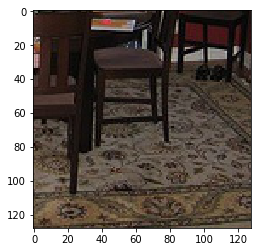

chair


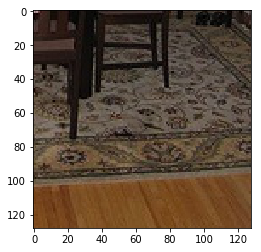

__background__


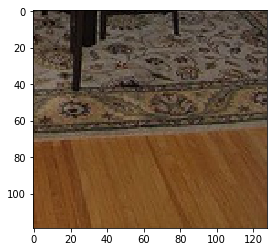

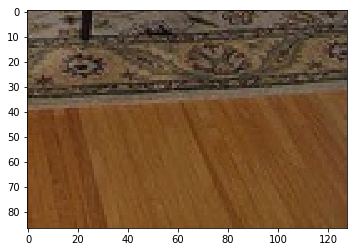

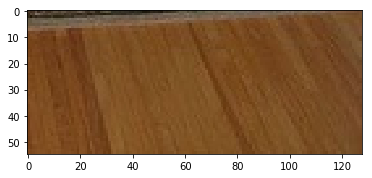

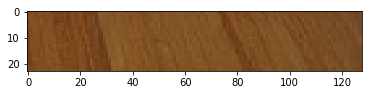

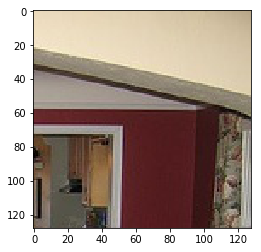

__background__


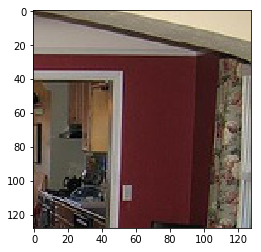

__background__


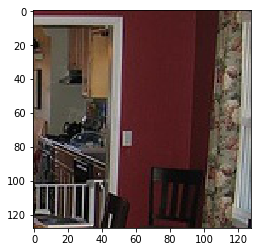

__background__


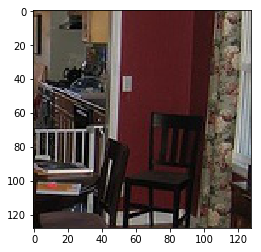

chair


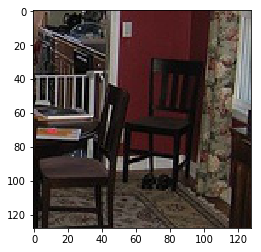

chair


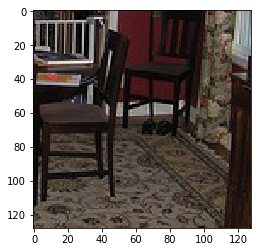

chair


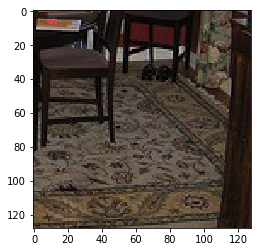

chair


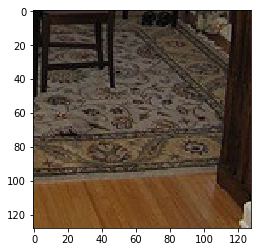

chair


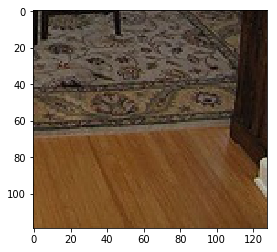

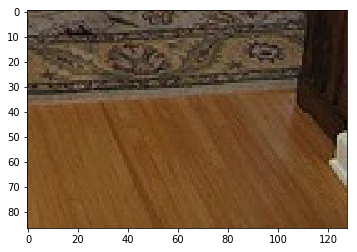

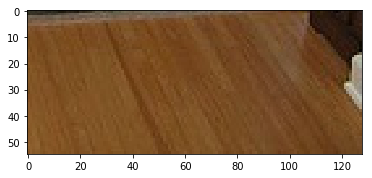

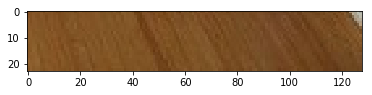

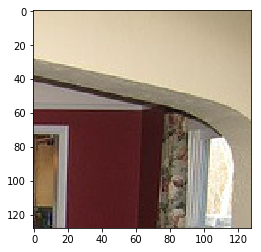

__background__


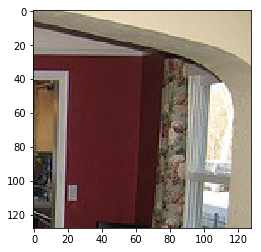

__background__


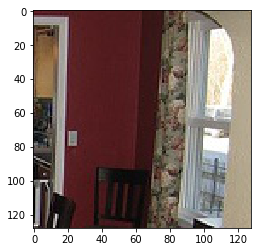

__background__


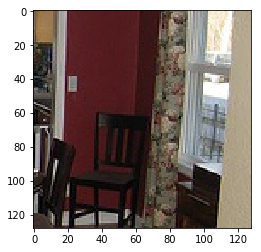

__background__


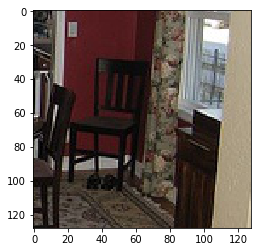

chair


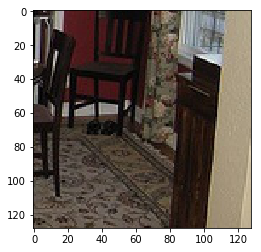

chair


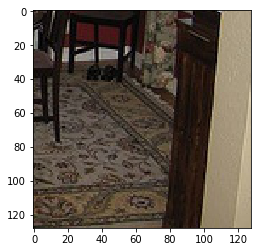

chair


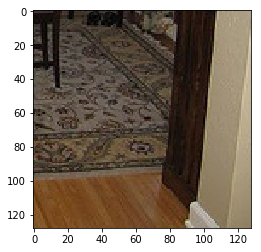

chair


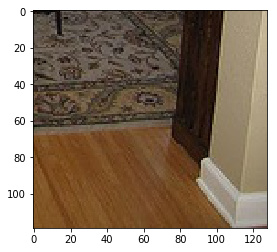

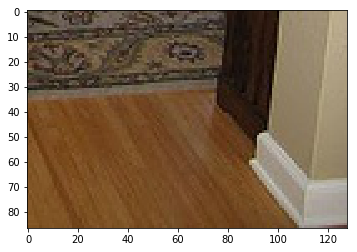

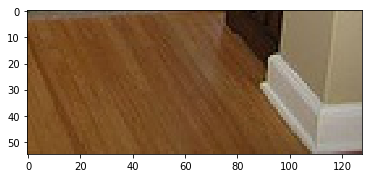

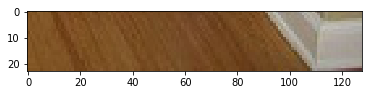

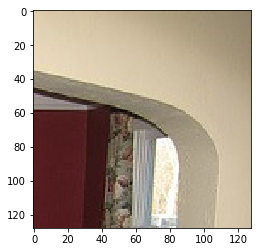

__background__


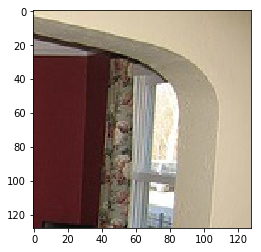

__background__


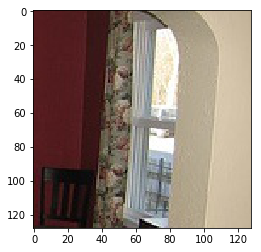

__background__


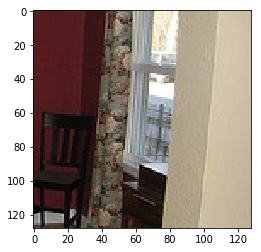

__background__


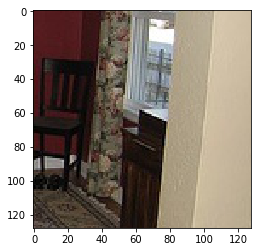

chair


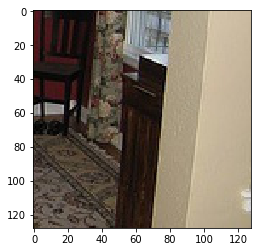

chair


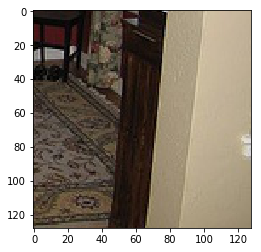

__background__


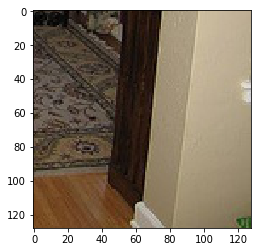

__background__


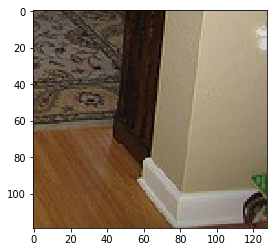

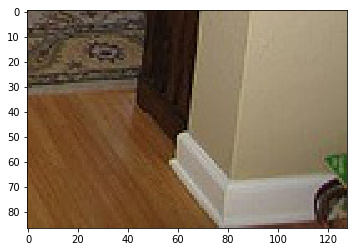

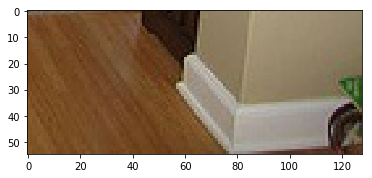

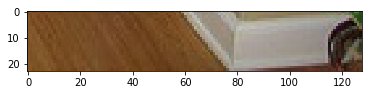

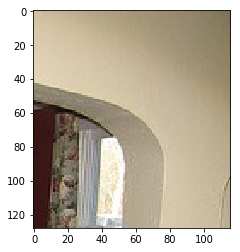

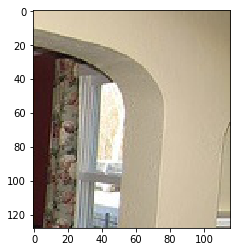

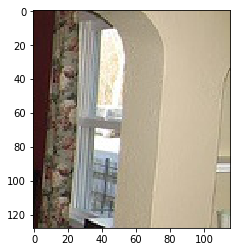

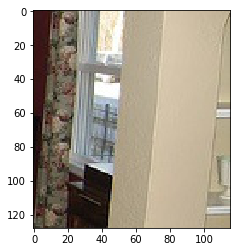

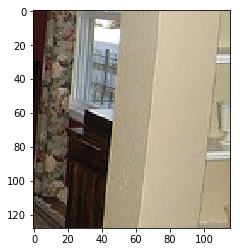

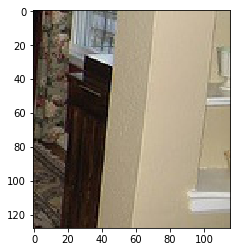

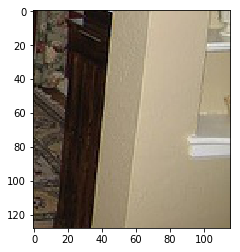

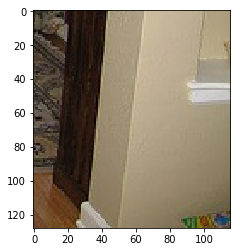

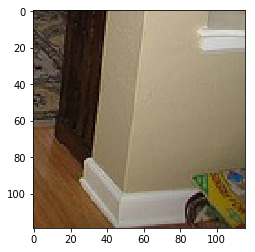

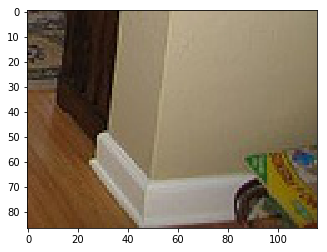

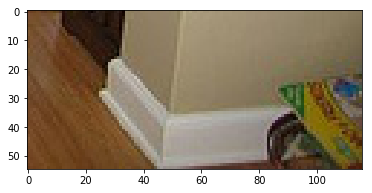

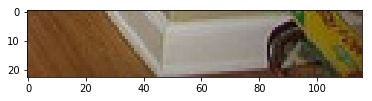

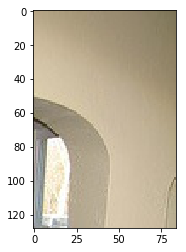

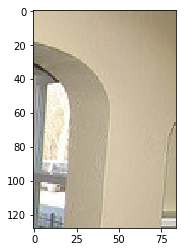

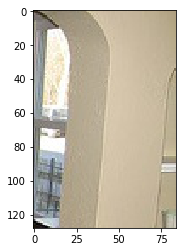

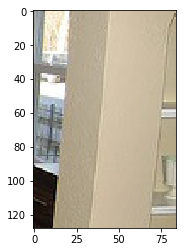

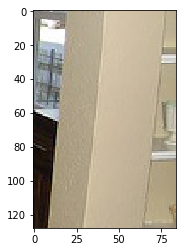

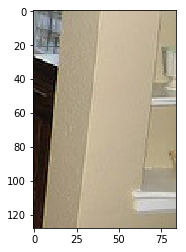

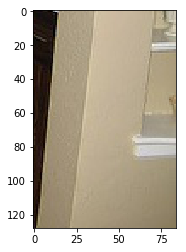

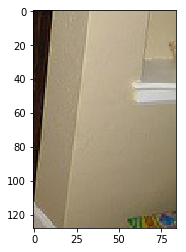

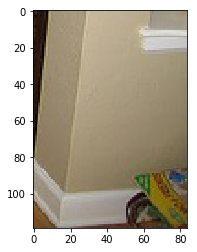

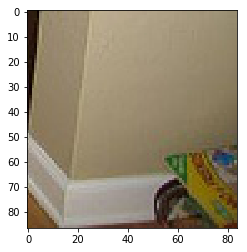

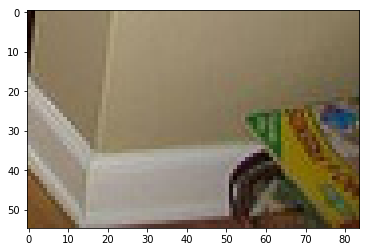

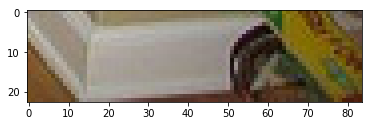

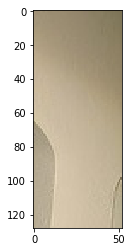

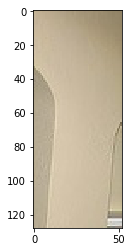

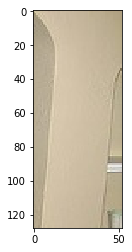

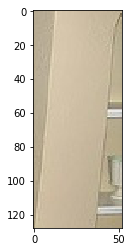

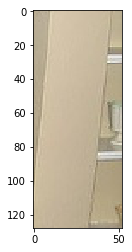

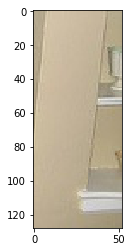

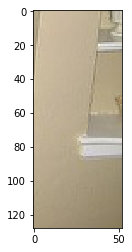

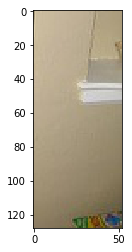

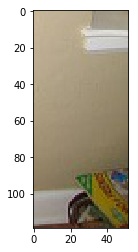

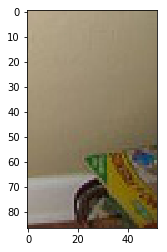

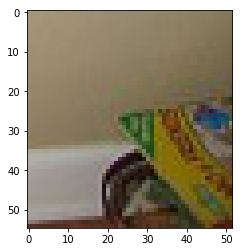

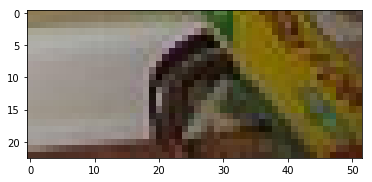

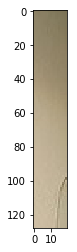

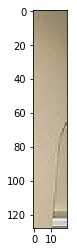

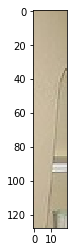

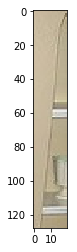

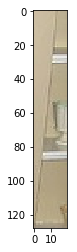

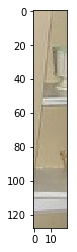

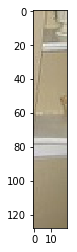

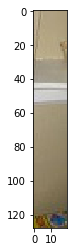

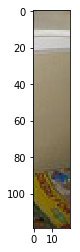

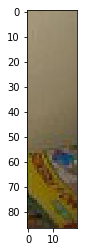

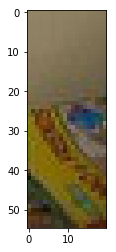

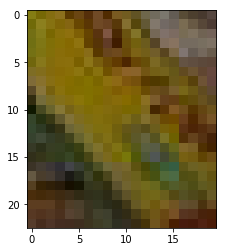

In [69]:
window_list = [(128,128), (256,256), (512,512)]
def sliding_window(image, step):
    # Begin
    image = np.asarray(image)
    for window in window_list:
        for x in range(0, image.shape[1], step):
            for y in range(0, image.shape[0], step):
                window_crop = image[y:y+window[1], x:x+window[0]]

                # Skip if not perfect size
                if window_crop.shape[0]!=window[0] or window_crop.shape[1]!=window[1]:
                    continue

                crop_window = Image.fromarray(window_crop)

                crop_window = test_transform(crop_window)
                crop_window = crop_window.unsqueeze(0)
                crop_window = crop_window.cuda()
                output = resnet18(crop_window)
                _, p = torch.max(output, 1)
                p = int(p)

                print(classes[p])
            
img = Image.open('/data/siddarth/Asgn3/test/VOC2007/JPEGImages/000084.jpg')
sliding_window(img, 32)
                

Apply non_maximum_supression to reduce the number of boxes. You are free to choose the threshold value for non maximum supression, but choose wisely [0,1].

In [ ]:
def non_maximum_supression(boxes,threshold = 0.3):
    # 

Test the trained model on the test dataset.

In [ ]:
#One Layer Detection
def test(resnet18):
    # Write loops for testing the model on the test set
    # Also print out the accuracy of the model

In [ ]:
%time test(resnet18)

In [ ]:
#Two Layer Detection
def test(resnet18):
    # Write loops for testing the model on the test set
    # Also print out the accuracy of the model

In [ ]:
%time test(resnet18)